# CSCN8010 Project

# Topic: Facial Expression Recognition using CNN

# Dataset: FER2013

# Group 5

# Kosisochukwu Ibe      8940079

# Amit Ghogre           8833038

# https://www.kaggle.com/datasets/msambare/fer2013/data

# Based on 2 already completed projects below:

# https://www.kaggle.com/code/ishantgargml/facial-expression-recognition-using-cnn/notebook

# https://www.kaggle.com/code/sanchukanirupama/facial-expression-recognition/notebook

The 2 completed projects we will base our work on generated 56% and 70% accuracy respectively.

The project with 56% accuracy didnt carry out augmentation on their train dataset while the one that got 70% accuracy carried out augmentation, although they also performed augmentation on the test dataset which is not advisable, hence why their accuracy was significantly higher than the other.

Both projects lacked more clarification on the model performance which we did add to our own work by employing performance metrics like Precision, Recall, F1-Score and Confusion Matrix.

We also built a shallow CNN Model to reduce computational cost while maintaining a good accuracy level hence making our model more efficient that the previous ones we used as reference.

The limitations of the FER2013 Dataset are class imbalance, occulusion, variation in lightning and diversity in shape of faces.

# Initialization

In [135]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.applications import MobileNetV2
from keras.optimizers import Adam

Importing all the necessary Libraries needed.

In [121]:
# Set the path to data folder
fer2013 = '/Users/engr/Desktop/FER2013'

train = '/Users/engr/Desktop/FER2013/train'

test = '/Users/engr/Desktop/FER2013/test'

Loading the dataset to the respective paths.

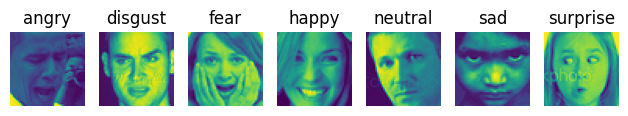

Train Folder:
happy: 7215 images
neutral: 4965 images
sad: 4830 images
fear: 4097 images
angry: 3995 images
surprise: 3171 images
disgust: 436 images

Test Folder:
happy: 1774 images
sad: 1247 images
neutral: 1233 images
fear: 1024 images
angry: 958 images
surprise: 831 images
disgust: 111 images


In [122]:
# Function to display one image from each class
def display_one_image(class_name, index):
    img_path = os.path.join(fer2013, "train", class_name, 
                            os.listdir(os.path.join(fer2013, "train", class_name))[10])
    img = Image.open(img_path)
    plt.subplot(1, num_cols, index)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_name)

# Set the number of columns based on the number of classes
num_cols = min(len(os.listdir(os.path.join(fer2013, "train"))), 8)

# Set up the grid
plt.figure(figsize=(9, 3))
[display_one_image(class_name, i + 1) for i, class_name in 
 enumerate(sorted([dir for dir in os.listdir(os.path.join(fer2013, "train")) 
 if os.path.isdir(os.path.join(fer2013, "train", dir)) and dir != '.DS_Store']))]

plt.show()

# Function to get the number of images in each folder
def get_image_counts(folder):
    return {class_name: len(os.listdir(os.path.join(fer2013, folder, class_name))) 
            for class_name in sorted([dir for dir in os.listdir(os.path.join(fer2013, folder)) 
            if os.path.isdir(os.path.join(fer2013, folder, dir)) and dir != '.DS_Store'])}

# Display the number of images from the "train" folder in descending order
print("Train Folder:")
train_counts = sorted(get_image_counts("train").items(), key=lambda x: x[1], reverse=True)
for class_name, num_images in train_counts:
    print(f"{class_name}: {num_images} images")

# Display the number of images from the "test" folder in descending order
print("\nTest Folder:")
test_counts = sorted(get_image_counts("test").items(), key=lambda x: x[1], reverse=True)
for class_name, num_images in test_counts:
    print(f"{class_name}: {num_images} images")


Exploration of the dataset to display one image from each class and list the total number of images contained in each class in descending order.

# Methodology

In [123]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.3,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Preprocessing 

# Define batch size
batch_size = 32

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(48, 48),
    batch_size=batch_size,
    shuffle=True,
    color_mode='grayscale',
    class_mode='categorical'
)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(48, 48),
    batch_size=batch_size,
    shuffle=False,
    color_mode='grayscale',
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Performing Datat Augmentation to help mitigate against the class imbalance.

Also carrying out preprocessing to prepare the data before fitting to the model.

In [124]:
# Building the CNN model

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 4, 4, 128)       

CNN Model configured with 3 convolutional layers with batch sizes 32, 64, 128 respectively.

The output class is predicted by the help of the Softmax function.

The CNN Model contains a total of about 355K parameters.

Input size is (48, 48, 1) indicating grayscale images of 48x48 size.

In [125]:
# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[early_stopping]
)

# Save the model
model.save('/Users/engr/Desktop/FER2013/my_model.keras')


Epoch 1/50
897/897 [==============================] - 63s 69ms/step - loss: 1.8037 - accuracy: 0.2507 - val_loss: 1.7921 - val_accuracy: 0.2514
Epoch 2/50
897/897 [==============================] - 65s 73ms/step - loss: 1.7871 - accuracy: 0.2523 - val_loss: 1.7536 - val_accuracy: 0.2754
Epoch 3/50
897/897 [==============================] - 65s 72ms/step - loss: 1.7712 - accuracy: 0.2637 - val_loss: 1.7230 - val_accuracy: 0.2866
Epoch 4/50
897/897 [==============================] - 59s 66ms/step - loss: 1.7550 - accuracy: 0.2743 - val_loss: 1.7076 - val_accuracy: 0.3045
Epoch 5/50
897/897 [==============================] - 62s 69ms/step - loss: 1.7325 - accuracy: 0.2862 - val_loss: 1.6349 - val_accuracy: 0.3450
Epoch 6/50
897/897 [==============================] - 64s 72ms/step - loss: 1.6980 - accuracy: 0.3118 - val_loss: 1.5799 - val_accuracy: 0.3884
Epoch 7/50
897/897 [==============================] - 62s 69ms/step - loss: 1.6540 - accuracy: 0.3366 - val_loss: 1.5536 - val_accuracy:

Training the model on the augmented train dataset with epoch=50.

The training stopped at epoch=40 due to the early stopping we included with patience=5 to help prevent overfitting by comparing the weights of val_loss to the previous optimal weight saved. The model stops training when there is no significant change after 5 epochs.

224/224 [==============================] - 7s 31ms/step - loss: 1.1806 - accuracy: 0.5554

Test Accuracy: 55.54%
225/225 [==============================] - 7s 32ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.47      0.41      0.44       958
     disgust       0.44      0.13      0.20       111
        fear       0.38      0.18      0.24      1024
       happy       0.77      0.81      0.79      1774
     neutral       0.45      0.68      0.54      1233
         sad       0.45      0.40      0.42      1247
    surprise       0.65      0.75      0.69       831

    accuracy                           0.56      7178
   macro avg       0.51      0.48      0.47      7178
weighted avg       0.54      0.56      0.54      7178

Confusion Matrix:
[[ 389    6   80   72  231  135   45]
 [  40   14    9   13   13   17    5]
 [ 131    2  181   83  235  213  179]
 [  49    3   23 1444  126   72   57]
 [  68    5   37   84  842  171   26]
 [

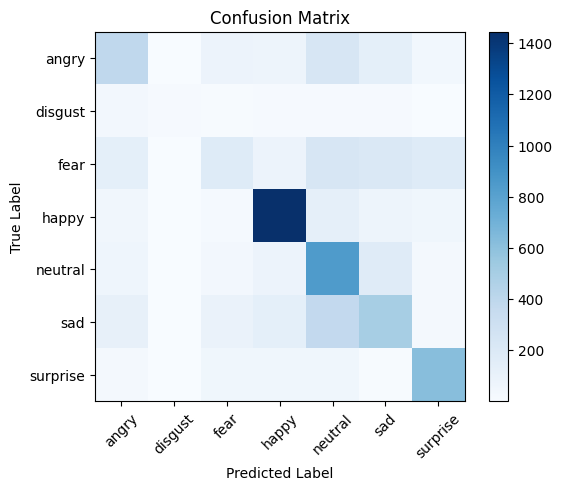

In [127]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'\nTest Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions on the test set
y_pred = model.predict(test_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true class labels
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names, zero_division=0))

print("Confusion Matrix:")
conf_mat = confusion_matrix(y_true, y_pred_classes)
print(conf_mat)

# Plot confusion matrix
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Evaluation of the model on the test dataset to see how the model performs to unseen data.

Model achieved an accuracy of 56% as can be seen above.

Precision, Recall and f1-score also reveals more insight on the balance between true positives and false negatives as well as true negatives and false negatives.

The confusion matrix also sheds more light on exactly how many times each class was rightly predicted and wrongly predicted and the class it mistook its prediction for.

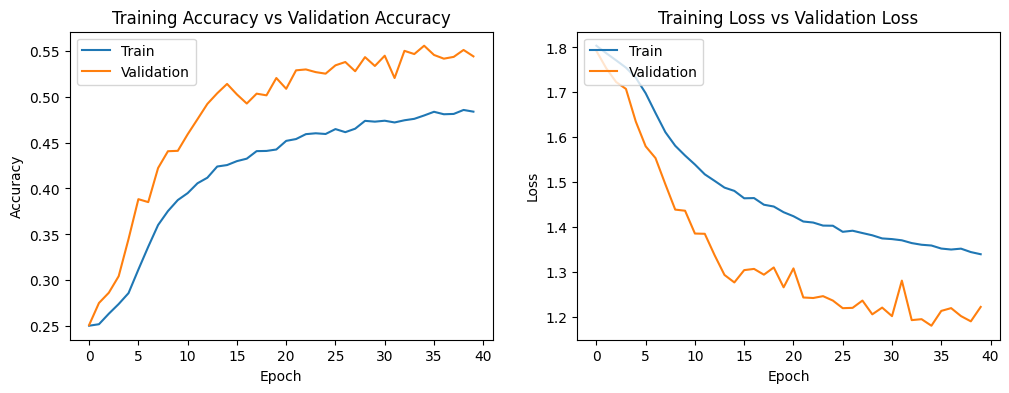

In [140]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

Plot shows the variation in the training accuracy against the validation accuracy likewise the loss function.

We also carried out training on 2 other models implementing Transfer Learning on VGG16 and Stratified K-Fold Validation, both were promising but had too much computational cost like training time.

The limitations of the FER2013 Dataset are class imbalance, occulusion, variation in lightning and diversity in shape of faces.

We also tried a different approach by reducing the classes in the dataset to only those that had approximately same number of data which were only 2 classes. The model we trained it on achieved 65% accuracy.

In summary facial expression recognition is vital in the world we live in today hence why there are so many researches on how to improve on it. We believe with more fine tuning like increasing the epochs and relaxing the patience we could generate a higher accuracy, also by increasing the cnn layers in our model.

For future work, we recommend gathering more raw data to balance the dataset and/or employing the use of high end cpu to successfully carry out the transfer learning with less computational cost.